In [2]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from math import pi
import numpy as np
import pandas as pd

np.random.seed(42)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns
sns.set_theme(style="white", context="talk")

import iqplot
import bokeh.io
from bokeh.layouts import column, gridplot
from bokeh.models import ColorBar, ColorMapper, LinearColorMapper, Ticker
bokeh.io.output_notebook()

from surprise import SVD, Reader
from surprise import Dataset
import sklearn
from surprise.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

import sgd_utils as sgd

Loading BokehJS ...

In [3]:
%load_ext blackcellmagic

In [4]:
def load_train_test(trainortest):
    """Load train or test data"""
    return pd.read_csv(
        "https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project2/data/"
        + trainortest,
        sep="\t",
        header=None,
        names=["USER", "MOVIE", "RATING"],
    )

In [5]:
def load_data(f_data, f_train, f_test, f_movies):
    """Load the user and movie data, FZL modified"""

    data = load_train_test(f_data)
    train = load_train_test(f_train)
    test = load_train_test(f_test)

    movies = pd.read_csv(
        "https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project2/data/"
        + f_movies,
        encoding="latin-1",
        sep="\t",
        header=None,
        names=[
            "MOVIE_ID",
            "TITLE",
            "UNKNOWN",
            "ACTION",
            "ADVENTURE",
            "ANIMATION",
            "CHILDREN",
            "COMEDY",
            "CRIME",
            "DOCUMENTARY",
            "DRAMA",
            "FANTASY",
            "FILM-NOIR",
            "HORROR",
            "MUSICAL",
            "MYSTERY",
            "ROMANCE",
            "SCI-FI",
            "THRILLER",
            "WAR",
            "WESTERN",
        ],
    )

    movies.loc[movies.TITLE == "unknown", "TITLE"] = "MOVIE_ID: " + movies.loc[
        movies.TITLE == "unknown", "MOVIE_ID"
    ].astype("str")

    return data, train, test, movies

In [6]:
def check_dup(df, df_details):
    """Check fi there are duplicated entries for each dataframe"""
    print(f"There are {sum((df.duplicated())*1)} duplicate entires in {df_details}")

In [9]:
data, Y_train_df, Y_test_df, movies = load_data(
    "data.txt", "train.txt", "test.txt", "movies.txt"
)

check_dup(Y_train_df, "Y_train_df")
check_dup(Y_test_df, "Y_test_df")

There are 0 duplicate entires in Y_train_df
There are 0 duplicate entires in Y_test_df


## Matrix Fduplicatedorization visualizations
### Method 1: HW5 solution

In [10]:
def get_MNY(Y_train_df, Y_test_df):
    """Return Y_train, Y_test, M, N, 
    where M is unique user IDs and N is unique movie IDs"""
    return (
        Y_train_df.to_numpy(),
        Y_test_df.to_numpy(),
        int(max(max(Y_train_df.USER), max(Y_test_df.USER))),
        int(max(max(Y_train_df.MOVIE), max(Y_test_df.MOVIE))),
    )

In [11]:
Y_train, Y_test, M, N = get_MNY(Y_train_df, Y_test_df)

In [12]:
print("Factorizing with ", M, " users, ", N, " movies.")
Ks = 20

reg = 0.0
eta = 0.03 # learning rate

# Use to compute Ein and Eout
U, V, err_training = sgd.train_model(M, N, Ks, eta, reg, Y_train)
print('Err training', err_training)
print('Err testing', sgd.get_err(U, V, Y_test))
print('dim U [m x k]', U.shape)
print('dim V [k x n]', V.shape)


Factorizing with  943  users,  1682  movies.
Epoch 1, E_in (regularized MSE): 0.5207409521962589
Epoch 2, E_in (regularized MSE): 0.39732417511546186
Epoch 3, E_in (regularized MSE): 0.35493382745895596
Epoch 4, E_in (regularized MSE): 0.32479318556966513
Epoch 5, E_in (regularized MSE): 0.3105305773075721
Epoch 6, E_in (regularized MSE): 0.2985793070586949
Epoch 7, E_in (regularized MSE): 0.28254062119373297
Epoch 8, E_in (regularized MSE): 0.27562186775616376
Epoch 9, E_in (regularized MSE): 0.26662010943131104
Epoch 10, E_in (regularized MSE): 0.26267616616953804
Epoch 11, E_in (regularized MSE): 0.2594009135425387
Epoch 12, E_in (regularized MSE): 0.25544874748619345
Epoch 13, E_in (regularized MSE): 0.2541855985502832
Epoch 14, E_in (regularized MSE): 0.2490519111271808
Epoch 15, E_in (regularized MSE): 0.24864946053440656
Err training 0.24864946053440656
Err testing 0.6633048138972973
dim U [m x k] (943, 20)
dim V [k x n] (20, 1682)


In [9]:
err_training

0.24864946053440656

In [13]:
## SVD

A, sigma, B = np.linalg.svd(V,  full_matrices=False)
A_two_cols = A[:, 0:2]

U_proj = A_two_cols.transpose()@U.transpose()
V_proj = A_two_cols.transpose()@V


In [14]:
def get_list_movies(data, head_no):
    """ selects the first head_no items from data and returns 3 lists of ids, genre and titles"""   

    list_movies_id = [d[1] for d in data.head(head_no).values]

    list_movies_genre = []
    list_movies_titles = []
    for idx in list_movies_id:
        movie_id_df = movies[movies["MOVIE_ID"] == idx]
        list_cols = []
        for i, v in enumerate(movie_id_df.values[0,:]):
            if v == 1:
                list_cols.append(movie_id_df.columns[i])
        list_movies_genre.append(list_cols)
        list_movies_titles.append(movie_id_df.values[0,1])
        
    return list_movies_id, list_movies_genre, list_movies_titles

# Some visualizations
def visualize(V_proj, movie_titles, movie_genre):
    """ Plots V_proj with annotations from the lists of ids, genre and titles"""   

    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.axhline(y=0, color='r')
    ax.axvline(x=0, color='r')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    m_proj0 = np.mean(V_proj[0,:])
    m_proj1 = np.mean(V_proj[1,:])
    ax.plot(V_proj[0,:] - m_proj0, V_proj[1,:] - m_proj1,'*')
    ax.set_xlabel('V proj 0')
    ax.set_ylabel('V proj 1')
    offset = 0.01
    for i, txt in enumerate(list_movies_titles):
        ax.annotate(txt, (V_proj[0][i] - m_proj0 + offset, V_proj[1][i] - m_proj1 + offset), fontsize=8)

    for i, txt in enumerate(list_movies_genre):
        ax.annotate(txt, (V_proj[0][i] - m_proj0, V_proj[1][i] - m_proj1 - 5*offset), fontsize=8)

    plt.show()


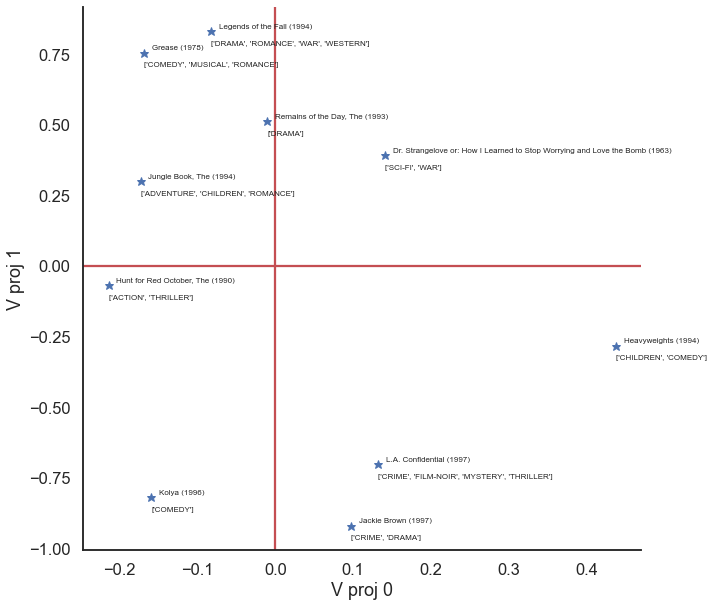

In [15]:
list_movies_id, list_movies_genre, list_movies_titles = get_list_movies(data, head_no=10)
visualize(V_proj[:,0:10], list_movies_titles, list_movies_genre)

### Method 2: Incorporate a and b for each user and move to model global tendencies of the various moves and users TODO

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9583  0.9634  0.9617  0.9615  0.9623  0.9614  0.0017  
MAE (testset)     0.7538  0.7630  0.7566  0.7548  0.7589  0.7574  0.0033  
Fit time          3.74    3.81    4.02    3.99    3.97    3.90    0.11    
Test time         0.08    0.08    0.08    0.08    0.17    0.10    0.04    
pu shape (943, 100)
qi shape (1668, 100)
user: 196        item: 302        r_ui = 4.00   est = 3.53   {'was_impossible': True, 'reason': 'User and item are unknown.'}


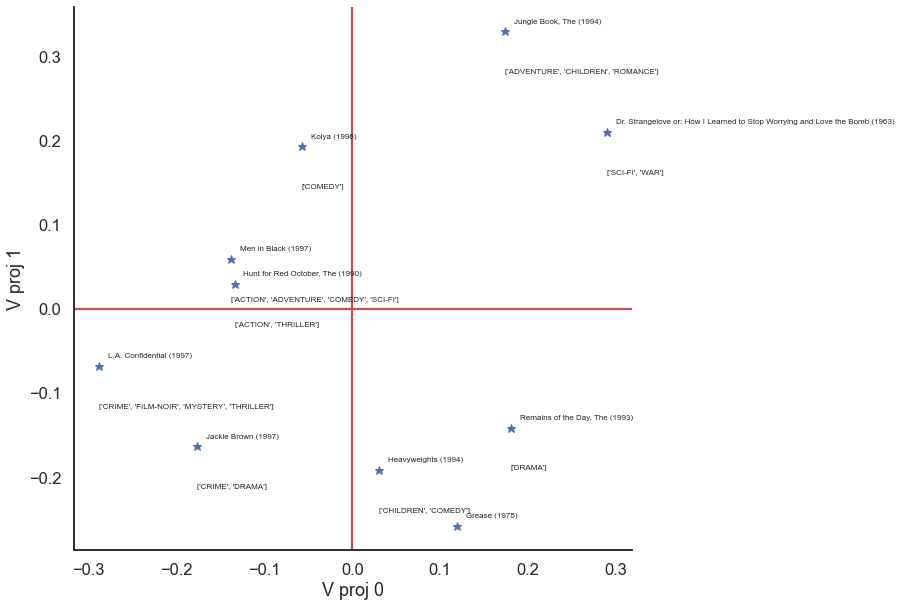

In [16]:
reader = Reader(rating_scale=(0,5))
train_dataset = Dataset.load_from_df(Y_train_df, reader)

train_dataset_object = train_dataset.build_full_trainset()

algo = SVD(biased=False)
cross_validate(algo, train_dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

algo.fit(train_dataset_object)

print('pu shape', algo.pu.shape)
print('qi shape', algo.qi.shape)

# sample of prediction
uid = str(196)  # raw user id (as in the ratings file). They are **strings**!
iid = str(302)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=4, verbose=True)

list_movies_id, list_movies_genre, list_movies_titles = get_list_movies(Y_train_df, head_no=10)
visualize(algo.qi[:,0:10], list_movies_titles, list_movies_genre)

# print('pu',algo.pu)
# print('qi',algo.qi)

### Method 3: off-the-shelf implementation 

In [10]:
reader = Reader(rating_scale=(0,5))
train_dataset = Dataset.load_from_df(Y_train_df, reader)

train_dataset_object = train_dataset.build_full_trainset()

algo = SVD()
cross_validate(algo, train_dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)

algo.fit(train_dataset_object)

print('pu shape', algo.pu.shape)
print('qi shape', algo.qi.shape)



Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9391  0.9463  0.9404  0.9477  0.9429  0.9433  0.0033  
MAE (testset)     0.7422  0.7468  0.7413  0.7464  0.7432  0.7440  0.0022  
Fit time          2.58    2.58    2.59    2.58    2.58    2.58    0.00    
Test time         0.08    0.08    0.13    0.07    0.07    0.09    0.02    
pu shape (943, 100)
qi shape (1663, 100)


In [11]:
# sample of prediction
uid = str(196)  # raw user id (as in the ratings file). They are **strings**!
iid = str(302)  # raw item id (as in the ratings file). They are **strings**!

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=4, verbose=True)



user: 196        item: 302        r_ui = 4.00   est = 3.53   {'was_impossible': False}


#### Visualization

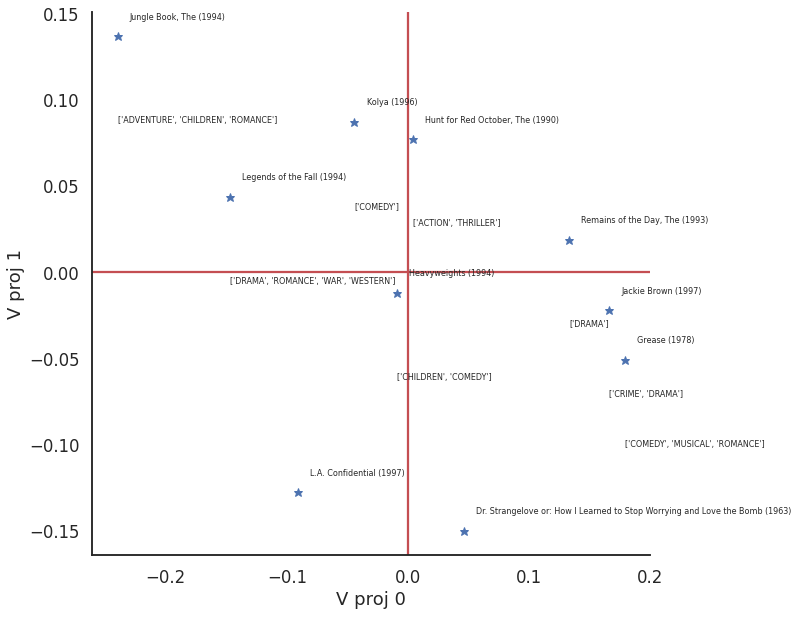

In [12]:
list_movies_id, list_movies_genre, list_movies_titles = get_list_movies(Y_train_df, head_no=10)
visualize(algo.qi[:,0:10], list_movies_titles, list_movies_genre)

# print('pu',algo.pu)
# print('qi',algo.qi)